# Importing libraries

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, f1_score, accuracy_score, confusion_matrix, precision_score, recall_score, precision_recall_curve, auc
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, cross_val_score

# Loading train and test data

## Train Data

In [2]:
msg_train = pd.read_csv('train.csv')
msg_train

,label,message,length
0,1,"['free2day', 'sexy', 'st', 'george', ""'s"", 'da...",26
1,0,"['armand', 'say', 'get', 'as', 'epsilon']",5
2,0,"['lol', 'i', ""'m"", 'hot', 'air', 'balloon', '!']",7
3,0,"['you', 'know', ',', 'wot', 'people', 'wear', ...",21
4,0,"['good', 'morning', ',', 'love', '...', 'i', '...",27
...,...,...,...
4454,0,"['hi', ',', 'wlcome', 'back', ',', 'wonder', '...",13
4455,1,"['ree', 'entry', '2', 'weekly', 'comp', 'chanc...",27
4456,0,"['``', 'oh', 'fuck', '.', 'juswoke', 'up', 'in...",31
4457,0,"['not', 'much', 'no', 'fights', '.', 'it', 'wa...",12


## Test Data

In [3]:
msg_test = pd.read_csv('test.csv')
msg_test

,label,message,length
0,0,"['you', 'still', 'coming', 'tonight', '?']",5
1,0,"['``', 'hey', 'babe', '!', 'far', '2', 'spun-o...",46
2,0,"['ya', 'even', 'cooky', 'jelly']",4
3,0,"['sorry', ""'ve"", 'gone', 'place', '.', 'i.ll',...",11
4,0,"['when', 'going', 'ride', 'bike', '?']",5
...,...,...,...
1110,0,"['my', 'supervisor', 'find', '4', 'one', 'lor'...",19
1111,1,"['bored', 'housewife', '!', 'chat', 'n', 'date...",14
1112,0,"['rose', 'red', ',', 'red', 'blood', ',', 'blo...",59
1113,0,"['also', 'remember', 'bead', ""n't"", 'come', '....",8


# Model Selection

We choose to use the following three models for spam/ham classification and record their Accuracy, Precision, Recall, F1-score and Area under the Precision-Recall respectively.

1. Naive Bayes
2. Logistic Regression
3. Support Vector Machine

In [4]:
models = ['Naive Bayes', 'Logistic Regression', 'Support Vector Machines']
f1 = []
acc = []
precision = []
recall = []
pr_auc = []

# 1. Naive Bayes Classifier

In [5]:
MultinomialNB().get_params() # Multinomial Naive Bayes

{'alpha': 1.0, 'class_prior': None, 'fit_prior': True, 'force_alpha': True}

## Creating pipeline

In [6]:
pipeline_nb = Pipeline([
    ('bow', CountVectorizer()),  # strings to token integer counts
    ('tfidf', TfidfTransformer()),  # integer counts to weighted TF-IDF scores
    ('classifier', MultinomialNB()),  # train on TF-IDF vectors w/ Naive Bayes classifier
])

## Cross Validation Scores

In [7]:
scores = cross_val_score(pipeline_nb,  # steps to convert raw messages into models
                         msg_train['message'],  # training data
                         msg_train['label'],  # training labels
                         cv=10,  # split data randomly into 10 parts: 9 for training, 1 for scoring
                         scoring='accuracy',  # which scoring metric?
                         n_jobs=-1,  # -1 = use all cores = faster
                         )
scores

array([0.96412556, 0.97982063, 0.96412556, 0.97757848, 0.96636771,
       0.97533632, 0.9529148 , 0.97982063, 0.96412556, 0.9505618 ])

In [8]:
scores.mean(), scores.std()

(np.float64(0.9674777044389581), np.float64(0.010008235582897696))

## Fitting the model

In [9]:
param_grid = {
    'classifier__alpha': [0.1, 0.2, 0.5, 1],
}

NB_Classifier = GridSearchCV(pipeline_nb, param_grid, cv=5, scoring='f1', verbose=1, n_jobs=-1)
NB_Classifier.fit(msg_train['message'], msg_train['label'])

print("Best parameters:", NB_Classifier.best_params_)
print("Best score:", NB_Classifier.best_score_)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


Best parameters: {'classifier__alpha': 0.1}
Best score: 0.9424178464178464


## Performance on Train Data

### Accuracy

In [10]:
predictions = NB_Classifier.predict(msg_train['message'])
accuracy_score(msg_train['label'], predictions)

0.9979816102265082

### Precision

In [11]:
precision_score(msg_train['label'], predictions)

1.0

### Recall

In [12]:
recall_score(msg_train['label'], predictions)

0.984641638225256

### F1 Score

In [13]:
f1_score(msg_train['label'], predictions, pos_label=1)

0.9922613929492692

### Precision-Recall Curve

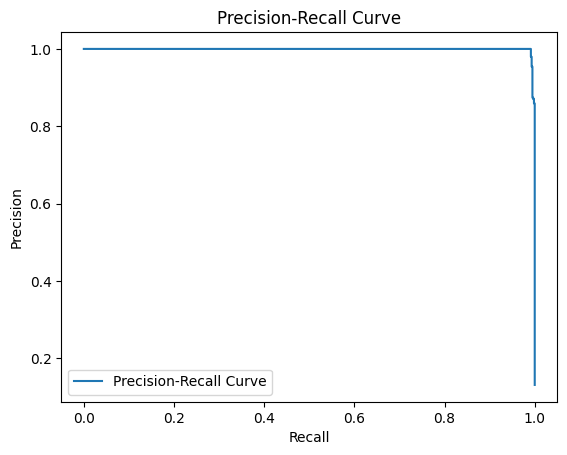

In [14]:
p, r, t = precision_recall_curve(msg_train['label'], NB_Classifier.predict_proba(msg_train['message'])[:,1],pos_label=1)
# plot the curve
plt.plot(r, p, label='Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.show()

In [15]:
auc_pr = auc(r,p)
# print the area under the curve
print('Area under the Precision-Recall Curve:', auc_pr)

Area under the Precision-Recall Curve: 0.9992110026145932


### Confusion Matrix

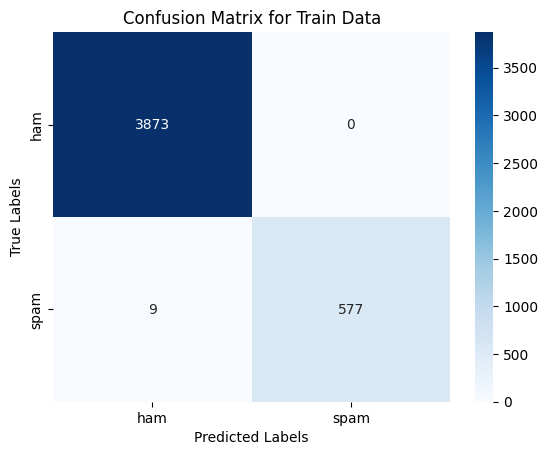

In [16]:
cm = confusion_matrix(msg_train['label'], predictions)
# Plot the confusion matrix
sns.heatmap(cm, annot=True, cmap='Blues', fmt='d', xticklabels=['ham', 'spam'], yticklabels=['ham','spam'])
plt.title('Confusion Matrix for Train Data')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

### Classification Report

In [17]:
print(classification_report(msg_train['label'], predictions, digits=4))

              precision    recall  f1-score   support

           0     0.9977    1.0000    0.9988      3873
           1     1.0000    0.9846    0.9923       586

    accuracy                         0.9980      4459
   macro avg     0.9988    0.9923    0.9956      4459
weighted avg     0.9980    0.9980    0.9980      4459



## Performance on Test Data

### Accuracy

In [18]:
predictions = NB_Classifier.predict(msg_test['message'])
accuracy = accuracy_score(msg_test['label'], predictions)
accuracy

0.9865470852017937

In [19]:
acc.append(accuracy)

### Precision

In [20]:
p = precision_score(msg_test['label'], predictions)
p

1.0

In [21]:
precision.append(p)

### Recall

In [22]:
r = recall_score(msg_test['label'], predictions)
r

0.906832298136646

In [23]:
recall.append(r)

### F1 Score

In [24]:
f = f1_score(msg_test['label'], predictions, pos_label=1)
f

0.9511400651465798

In [25]:
f1.append(f)

### Precision-Recall Curve

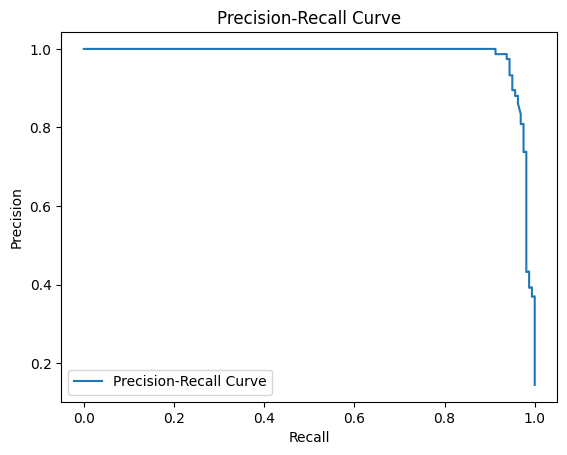

In [26]:
p, r, t = precision_recall_curve(msg_test['label'], NB_Classifier.predict_proba(msg_test['message'])[:,1],pos_label=1)
# plot the curve
plt.plot(r, p, label='Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.show()

In [27]:
auc_pr = auc(r,p)
# print the area under the curve
print('Area under the Precision-Recall Curve:', auc_pr)

Area under the Precision-Recall Curve: 0.9827191491550886


In [28]:
pr_auc.append(auc_pr)

### Confusion Matrix

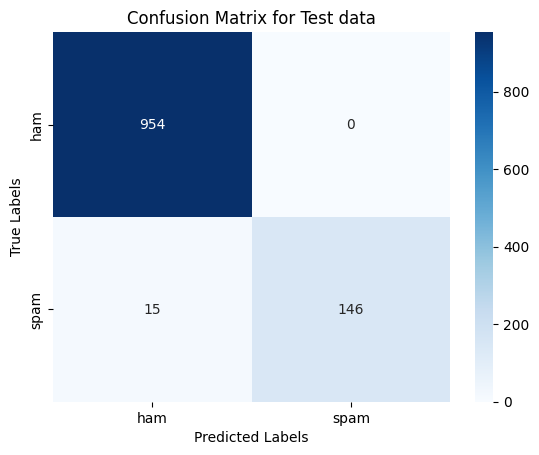

In [29]:
cm = confusion_matrix(msg_test['label'], predictions)
# Plot the confusion matrix
sns.heatmap(cm, annot=True, cmap='Blues', fmt='d', xticklabels=['ham', 'spam'], yticklabels=['ham','spam'])
plt.title('Confusion Matrix for Test data')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

### Classification Report

In [30]:
print(classification_report(msg_test['label'], predictions, digits=4))

              precision    recall  f1-score   support

           0     0.9845    1.0000    0.9922       954
           1     1.0000    0.9068    0.9511       161

    accuracy                         0.9865      1115
   macro avg     0.9923    0.9534    0.9717      1115
weighted avg     0.9868    0.9865    0.9863      1115



# 2. Logistic Regression

In [31]:
LogisticRegression().get_params()

{'C': 1.0,
 'class_weight': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 100,
 'multi_class': 'deprecated',
 'n_jobs': None,
 'penalty': 'l2',
 'random_state': None,
 'solver': 'lbfgs',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}

## Creating Pipeline

In [32]:
pipeline_LR = Pipeline([
    ('bow', CountVectorizer()),  # strings to token integer counts
    ('tfidf', TfidfTransformer()),  # integer counts to weighted TF-IDF scores
    ('classifier', LogisticRegression(random_state=42, max_iter=500))  # train on TF-IDF vectors w/ logistic regression
])

## Cross Validation Scores

In [33]:
scores = cross_val_score(pipeline_LR,  # steps to convert raw messages into models
                         msg_train['message'],  # training data
                         msg_train['label'],  # training labels
                         cv=10,  # split data randomly into 10 parts: 9 for training, 1 for scoring
                         scoring='f1',  # which scoring metric?
                         n_jobs=-1,  # -1 = use all cores = faster
                         )
scores

array([0.82352941, 0.91891892, 0.85436893, 0.91891892, 0.85436893,
       0.85714286, 0.75268817, 0.87619048, 0.85148515, 0.75789474])

In [34]:
scores.mean(), scores.std()

(np.float64(0.8465506504413515), np.float64(0.053676494204674005))

## Fitting the model

In [35]:
param_grid = {
    'classifier__C': [1, 5, 10, 25, 50],
    'classifier__class_weight': [None, 'balanced']
}

LR_Classifier = GridSearchCV(pipeline_LR, param_grid, cv=5, scoring='f1', verbose=1, n_jobs=-1)
LR_Classifier.fit(msg_train['message'], msg_train['label'])

print("Best parameters:", LR_Classifier.best_params_)
print("Best score:", LR_Classifier.best_score_)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


Best parameters: {'classifier__C': 50, 'classifier__class_weight': 'balanced'}
Best score: 0.9535039925323918


## Performance on Train Data

### Accuracy

In [36]:
predictions = LR_Classifier.predict(msg_train['message'])
accuracy_score(msg_train['label'],predictions)

1.0

### Precision

In [37]:
precision_score(msg_train['label'], predictions)

1.0

### Recall

In [38]:
recall_score(msg_train['label'], predictions)

1.0

### F1 Score

In [39]:
f1_score(msg_train['label'], predictions, pos_label=1)

1.0

### Precision-Recall Curve

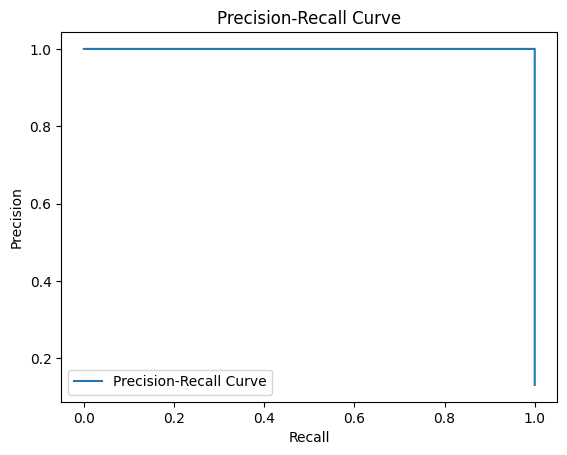

In [40]:
p, r, t = precision_recall_curve(msg_train['label'], LR_Classifier.predict_proba(msg_train['message'])[:,1],pos_label=1)
# plot the curve
plt.plot(r, p, label='Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.show()

In [41]:
auc_pr = auc(r,p)
# print the area under the curve
print('Area under the Precision-Recall Curve:', auc_pr)

Area under the Precision-Recall Curve: 1.0


### Confusion Matrix

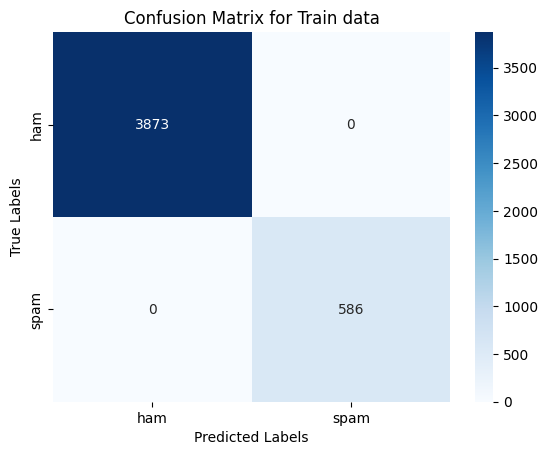

In [42]:
cm = confusion_matrix(msg_train['label'], predictions)
# Plot the confusion matrix
sns.heatmap(cm, annot=True, cmap='Blues', fmt='d', xticklabels=['ham', 'spam'], yticklabels=['ham','spam'])
plt.title('Confusion Matrix for Train data')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

### Classification Report

In [43]:
print(classification_report(msg_train['label'],predictions,digits=4))

              precision    recall  f1-score   support

           0     1.0000    1.0000    1.0000      3873
           1     1.0000    1.0000    1.0000       586

    accuracy                         1.0000      4459
   macro avg     1.0000    1.0000    1.0000      4459
weighted avg     1.0000    1.0000    1.0000      4459



## Performance on Test Data

### Accuracy

In [44]:
predictions = LR_Classifier.predict(msg_test['message'])
accuracy = accuracy_score(msg_test['label'], predictions)
accuracy

0.9838565022421525

In [45]:
acc.append(accuracy)

### Precision

In [46]:
p = precision_score(msg_test['label'], predictions)
p

0.9554140127388535

In [47]:
precision.append(p)

### Recall

In [48]:
r = recall_score(msg_test['label'], predictions)
r

0.9316770186335404

In [49]:
recall.append(r)

### F1 Score

In [50]:
f = f1_score(msg_test['label'], predictions, pos_label=1)
f

0.9433962264150944

In [51]:
f1.append(f)

### Precision-Recall Curve

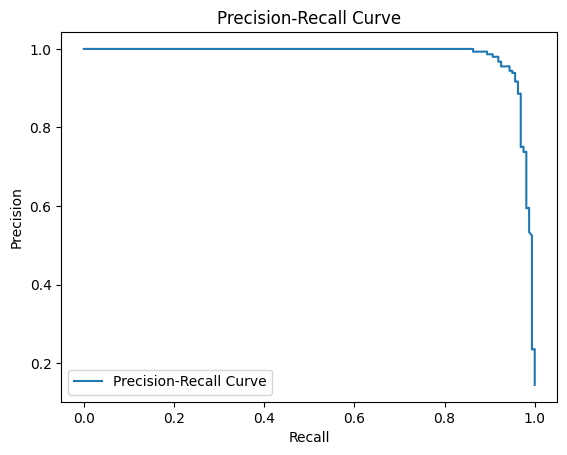

In [52]:
p, r, t = precision_recall_curve(msg_test['label'], LR_Classifier.predict_proba(msg_test['message'])[:,1],pos_label=1)
# plot the curve
plt.plot(r, p, label='Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.show()

In [53]:
auc_pr = auc(r,p)
# print the area under the curve
print('Area under the Precision-Recall Curve:', auc_pr)

Area under the Precision-Recall Curve: 0.9830132323905554


In [54]:
pr_auc.append(auc_pr)

### Confusion Matrix

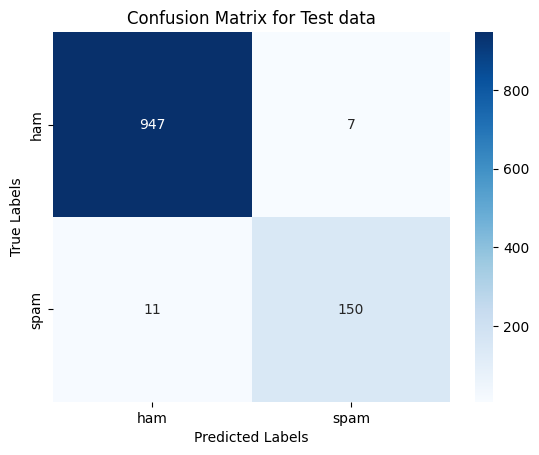

In [55]:
cm = confusion_matrix(msg_test['label'], predictions)
# Plot the confusion matrix
sns.heatmap(cm, annot=True, cmap='Blues', fmt='d', xticklabels=['ham', 'spam'], yticklabels=['ham','spam'])
plt.title('Confusion Matrix for Test data')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

### Classification Report

In [56]:
print(classification_report(msg_test['label'], predictions,digits=4))

              precision    recall  f1-score   support

           0     0.9885    0.9927    0.9906       954
           1     0.9554    0.9317    0.9434       161

    accuracy                         0.9839      1115
   macro avg     0.9720    0.9622    0.9670      1115
weighted avg     0.9837    0.9839    0.9838      1115



# 3. Support Vector Machines

In [57]:
SVC().get_params()

{'C': 1.0,
 'break_ties': False,
 'cache_size': 200,
 'class_weight': None,
 'coef0': 0.0,
 'decision_function_shape': 'ovr',
 'degree': 3,
 'gamma': 'scale',
 'kernel': 'rbf',
 'max_iter': -1,
 'probability': False,
 'random_state': None,
 'shrinking': True,
 'tol': 0.001,
 'verbose': False}

## Creating Pipeline

In [58]:
pipeline_svm = Pipeline([
    ('bow', CountVectorizer()),  # strings to token integer counts
    ('tfidf', TfidfTransformer()),  # integer counts to weighted TF-IDF scores
    ('classifier', SVC(probability=True, random_state=42))  # train on TF-IDF vectors w/ SVM classifier
])

## Cross Validation Score

In [59]:
scores = cross_val_score(pipeline_svm,  # steps to convert raw messages into models
                         msg_train['message'],  # training data
                         msg_train['label'],  # training labels
                         cv=10,  # split data randomly into 10 parts: 9 for training, 1 for scoring
                         scoring='f1',  # which scoring metric?
                         n_jobs=-1,  # -1 = use all cores = faster
                         )
scores

array([0.9380531 , 0.96491228, 0.92727273, 0.97391304, 0.90740741,
       0.91743119, 0.85148515, 0.95495495, 0.92592593, 0.90566038])

In [60]:
scores.mean(), scores.std()

(np.float64(0.9267016155620056), np.float64(0.03342972760001904))

## Fitting the model

In [61]:
param_grid = {
    'classifier__C': [0.5 ,1, 5, 10],
    'classifier__kernel': ['linear', 'rbf', 'poly'],
    'classifier__gamma': ['scale', 'auto']
}

svm_classifier = GridSearchCV(pipeline_svm, param_grid, cv=4, scoring='f1',verbose=1, n_jobs=-1)
svm_classifier.fit(msg_train['message'], msg_train['label'])

print("Best parameters:", svm_classifier.best_params_)
print("Best score:", svm_classifier.best_score_)

Fitting 4 folds for each of 24 candidates, totalling 96 fits


Best parameters: {'classifier__C': 5, 'classifier__gamma': 'scale', 'classifier__kernel': 'linear'}
Best score: 0.9518259660158179


## Performance on Train Data

### Accuracy

In [62]:
predictions = svm_classifier.predict(msg_train['message'])
accuracy_score(msg_train['label'], predictions)

1.0

### Precision

In [63]:
precision_score(msg_train['label'], predictions)

1.0

### Recall

In [64]:
recall_score(msg_train['label'], predictions)

1.0

### F1 Score

In [65]:
f1_score(msg_train['label'], predictions, pos_label=1)

1.0

### Precision-Recall Curve

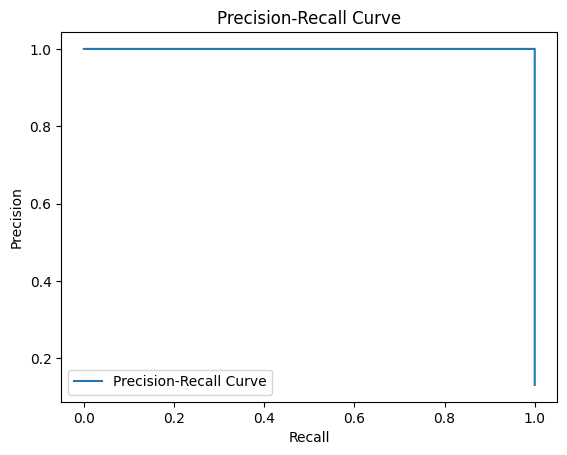

In [66]:
p, r, t = precision_recall_curve(msg_train['label'], svm_classifier.predict_proba(msg_train['message'])[:,1],pos_label=1)
# plot the curve
plt.plot(r, p, label='Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.show()

In [67]:
auc_pr = auc(r,p)
# print the area under the curve
print('Area under the Precision-Recall Curve:', auc_pr)

Area under the Precision-Recall Curve: 1.0


### Confusion Matrix

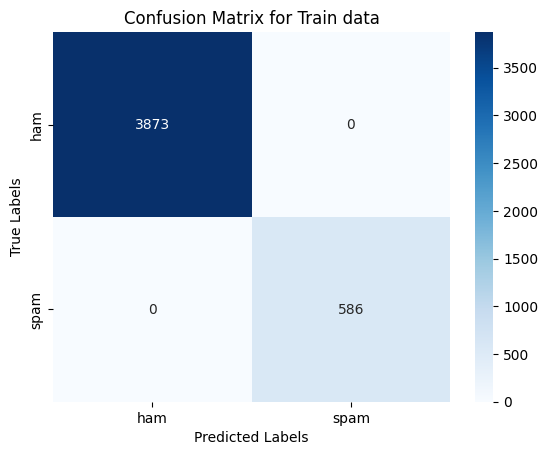

In [68]:
cm = confusion_matrix(msg_train['label'], predictions)
# Plot the confusion matrix
sns.heatmap(cm, annot=True, cmap='Blues', fmt='d', xticklabels=['ham', 'spam'], yticklabels=['ham','spam'])
plt.title('Confusion Matrix for Train data')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

### Classification Report

In [69]:
print(classification_report(msg_train['label'], predictions, digits=4))

              precision    recall  f1-score   support

           0     1.0000    1.0000    1.0000      3873
           1     1.0000    1.0000    1.0000       586

    accuracy                         1.0000      4459
   macro avg     1.0000    1.0000    1.0000      4459
weighted avg     1.0000    1.0000    1.0000      4459



## Performance on Test Data

### Accuracy

In [70]:
predictions = svm_classifier.predict(msg_test['message'])
accuracy = accuracy_score(msg_test['label'], predictions)
accuracy

0.9865470852017937

In [71]:
acc.append(accuracy)

### Precision

In [72]:
p = precision_score(msg_test['label'], predictions)
p

0.9802631578947368

In [73]:
precision.append(p)

### Recall

In [74]:
r = recall_score(msg_test['label'], predictions)
r

0.9254658385093167

In [75]:
recall.append(r)

### F1 Score

In [76]:
f = f1_score(msg_test['label'], predictions, pos_label=1)
f

0.952076677316294

In [77]:
f1.append(f)

### Precision-Recall Curve

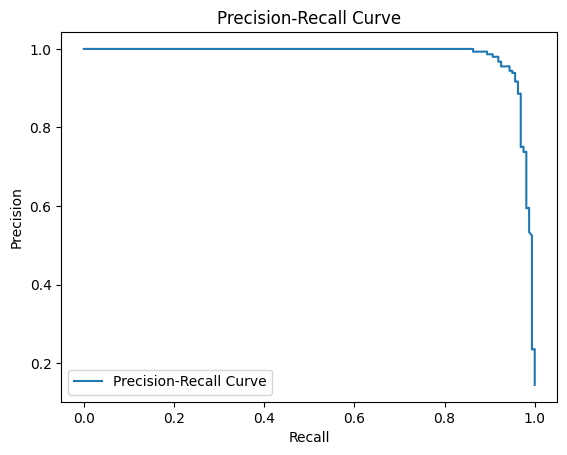

In [78]:
p, r, t = precision_recall_curve(msg_test['label'], LR_Classifier.predict_proba(msg_test['message'])[:,1],pos_label=1)
# plot the curve
plt.plot(r, p, label='Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.show()

In [79]:
auc_pr = auc(r,p)
# print the area under the curve
print('Area under the Precision-Recall Curve:', auc_pr)

Area under the Precision-Recall Curve: 0.9830132323905554


In [80]:
pr_auc.append(auc_pr)

### Confusion Matrix

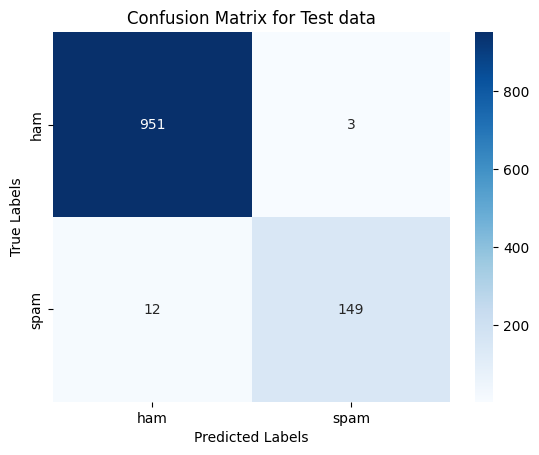

In [81]:
cm = confusion_matrix(msg_test['label'], predictions)
# Plot the confusion matrix
sns.heatmap(cm, annot=True, cmap='Blues', fmt='d', xticklabels=['ham', 'spam'], yticklabels=['ham','spam'])
plt.title('Confusion Matrix for Test data')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

### Classification Report

In [82]:
print(classification_report(msg_test['label'], predictions,digits=4))

              precision    recall  f1-score   support

           0     0.9875    0.9969    0.9922       954
           1     0.9803    0.9255    0.9521       161

    accuracy                         0.9865      1115
   macro avg     0.9839    0.9612    0.9721      1115
weighted avg     0.9865    0.9865    0.9864      1115



# Benchmarking the performance

In [83]:
# Performance of models across various metrics
pd.DataFrame({'Model':models, 'F1 Score':f1, 'Accuracy':acc, 'Precision':precision, 'Recall':recall, 'AUC-PR':pr_auc})

,Model,F1 Score,Accuracy,Precision,Recall,AUC-PR
0,Naive Bayes,0.951140,0.986547,1.000000,0.906832,0.982719
1,Logistic Regression,0.943396,0.983857,0.955414,0.931677,0.983013
2,Support Vector Machines,0.952077,0.986547,0.980263,0.925466,0.983013


# Best Model

We consider the following:
- Excessive spam can negatively impact user experience.
- Misclassifying ham as spam is more harmful than missing some spam.

Based on this, we prioritize high precision (to avoid misclassifying ham as spam) over high recall (since capturing all spam is less critical).

Since all models achieve a recall greater than 0.90 (meaning they are all fairly good at detecting spam), and Naive Bayes has the highest precision, it is the best choice for spam/ham classification.